In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import joblib
from sklearn.model_selection import KFold

In [9]:
data = pd.read_csv('bio copy.csv')
gender = {"M":1,"F":0}
data["Gender"] = data["Gender"].map(gender)
data.dropna(inplace=True)
data.drop(34, inplace=True)
data.reset_index(drop=True, inplace=True)
X = data[["Age","Gender","BMI","Body weight ","Height "]].values
data["HOMA-IR"] = data["Fasting GLU - PDL (Lab)"] * data["Insulin "] / 405
y = data["HOMA-IR"].values.reshape(-1, 1)

R² score: 0.3878


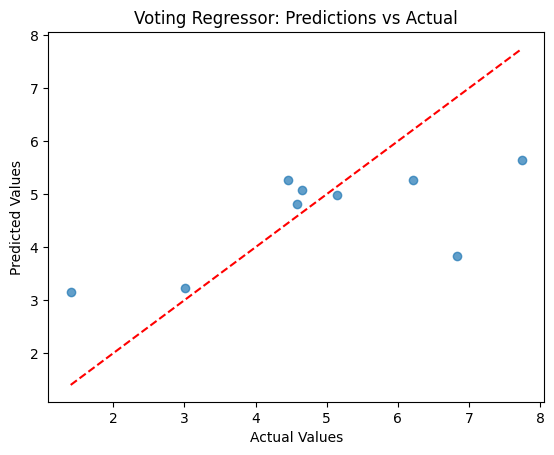

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

data = pd.read_csv('bio copy.csv')
gender = {"M": 1, "F": 0}
data["Gender"] = data["Gender"].map(gender)
data.dropna(inplace=True)
data.drop(34, inplace=True)
data.reset_index(drop=True, inplace=True)

# Define features (X) and target (y)
X = data[["Age", "Gender", "BMI", "Body weight ", "Height "]].values
data["HOMA-IR"] = data["Fasting GLU - PDL (Lab)"] * data["Insulin "] / 405
y = data["HOMA-IR"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

X_train = X_train_scaled
y_train = y_train_scaled
X_test = X_test_scaled
y_test = y_test_scaled
# Initialize and train the KNN regressor
knn = KNeighborsRegressor(n_neighbors=6)  # You can tune n_neighbors
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2:.4f}")

# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.scatter(y_scaler.inverse_transform(y_test.reshape(-1,1)), y_scaler.inverse_transform(y_pred.reshape(-1,1)), alpha=0.7)

plt.plot([min(y_scaler.inverse_transform(y_test.reshape(-1,1))), max(y_scaler.inverse_transform(y_test.reshape(-1,1)))], [min(y_scaler.inverse_transform(y_test.reshape(-1,1))), max(y_scaler.inverse_transform(y_test.reshape(-1,1)))], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Voting Regressor: Predictions vs Actual")
plt.show()

In [130]:
from sklearn.ensemble import RandomForestRegressor
data = pd.read_csv('bio copy.csv')
gender = {"M":1,"F":0}
data["Gender"] = data["Gender"].map(gender)
data.dropna(inplace=True)
data.drop(34, inplace=True)
data.reset_index(drop=True, inplace=True)
X = data[["Age","Gender","BMI","Body weight ","Height "]].values
data["HOMA-IR"] = data["Fasting GLU - PDL (Lab)"] * data["Insulin "] / 405
y = data["HOMA-IR"].values.reshape(-1, 1)
rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"R² score: {r2_score(y_test, y_pred):.4f}")

plt.scatter(y_scaler.inverse_transform(y_test.reshape(-1,1)), y_scaler.inverse_transform(y_pred.reshape(-1,1)), alpha=0.7)

plt.plot([min(y_scaler.inverse_transform(y_test.reshape(-1,1))), max(y_scaler.inverse_transform(y_test.reshape(-1,1)))], [min(y_scaler.inverse_transform(y_test.reshape(-1,1))), max(y_scaler.inverse_transform(y_test.reshape(-1,1)))], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Voting Regressor: Predictions vs Actual")
plt.show()

R² score: 0.5716


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

R² score: 0.3285


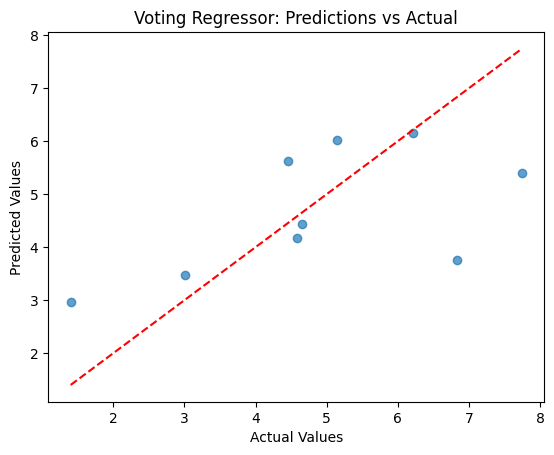

In [116]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
ridge = Ridge(alpha=1.0)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Create a Voting Regressor
voting_regressor = VotingRegressor(estimators=[
    ('rf', rf),
    ('ridge', ridge),
    ('svr', svr)
])

# Train the Voting Regressor
voting_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = voting_regressor.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2:.4f}")

# Plot predictions vs actual values
plt.scatter(y_scaler.inverse_transform(y_test.reshape(-1,1)), y_scaler.inverse_transform(y_pred.reshape(-1,1)), alpha=0.7)

plt.plot([min(y_scaler.inverse_transform(y_test.reshape(-1,1))), max(y_scaler.inverse_transform(y_test.reshape(-1,1)))], [min(y_scaler.inverse_transform(y_test.reshape(-1,1))), max(y_scaler.inverse_transform(y_test.reshape(-1,1)))], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Voting Regressor: Predictions vs Actual")
plt.show()

In [92]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
joblib.dump(x_scaler, 'x_scaler.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

ValueError: Expected 2D array, got 1D array instead:
array=[0.5617284  3.39851852 5.06962963 5.02962963 4.58666667 1.51703704
 4.24       4.89481481 7.7417284  3.77777778 3.12197531 5.96666667
 4.65407407 3.8837037  0.72518519 6.67654321 1.92345679 4.42518519
 4.50074074 5.08320988 2.25037037 0.8454321  1.73333333 4.5708642
 1.4        6.21037037 6.64888889 5.05555556 2.36740741 0.79012346
 3.32246914 0.82962963 7.96641975 1.3217284  6.82716049 3.61185185
 4.45283951 5.1437037  3.96666667 3.00395062 3.59259259 1.98962963
 9.20888889].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [28]:
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.model(x)

Early stopping at epoch 14
Fold 1 R²: -0.0941


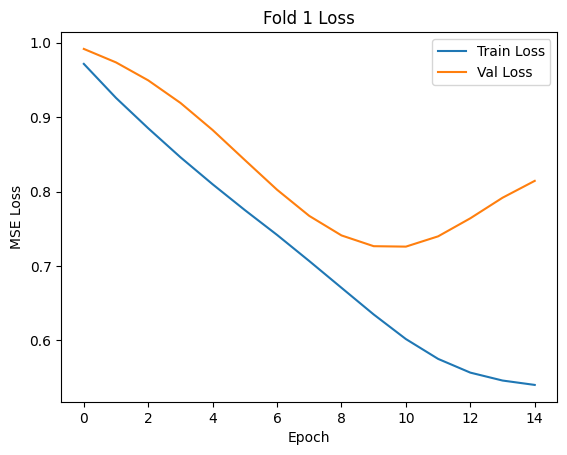

Early stopping at epoch 27
Fold 1 R²: 0.3998


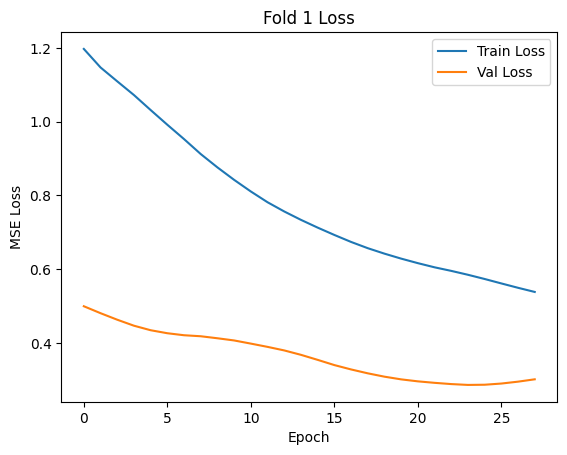

Early stopping at epoch 19
Fold 1 R²: 0.2590


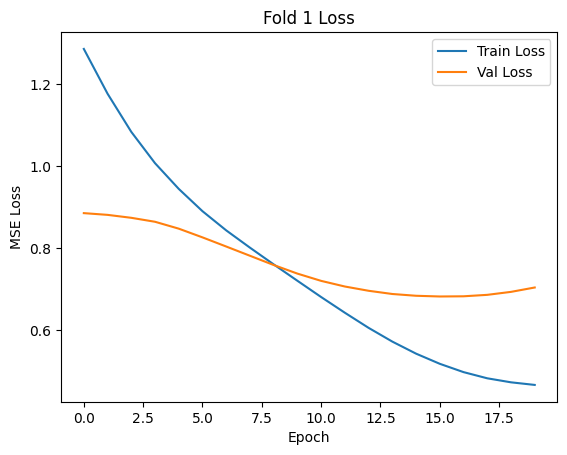

Early stopping at epoch 17
Fold 1 R²: 0.2053


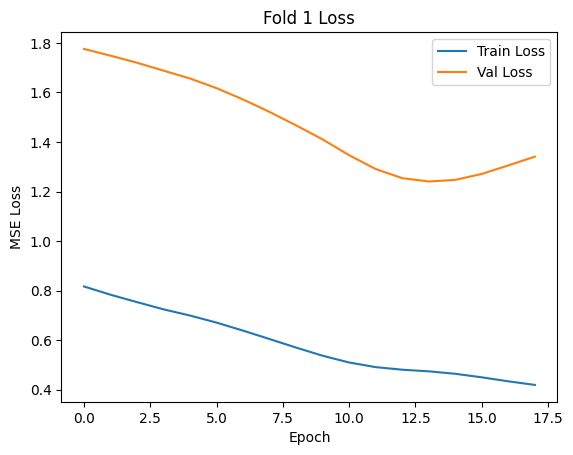

Early stopping at epoch 15
Fold 1 R²: -0.5549


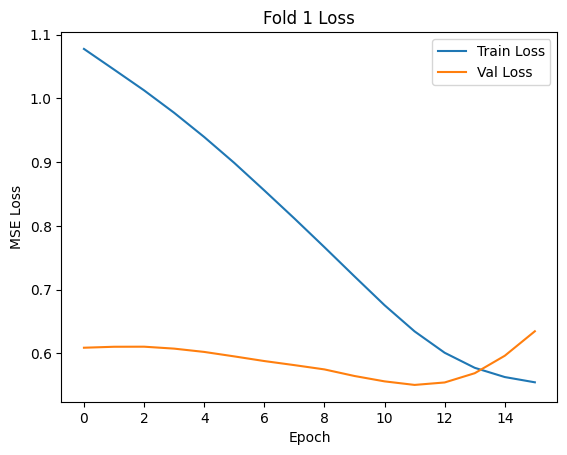


Average R² across folds: 0.0430


In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_r2_scores = []
for train_index, test_index in kf.split(X_tensor):
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]

    model = RegressionNN()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.01)
    best_loss = float('inf')
    patience = 4
    trigger_times = 0
    best_model_state = None
    train_losses = []
    val_losses = []
    num_epochs = 1000

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        val_loss = criterion(model(X_test), y_test).item()
        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_pred_inv = y_scaler.inverse_transform(y_pred)
        y_val_inv = y_scaler.inverse_transform(y_test.numpy())
        r2 = r2_score(y_val_inv, y_pred_inv)
        all_r2_scores.append(r2)
        print(f"Fold {fold} R²: {r2:.4f}")

    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Fold {fold} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

print(f"\nAverage R² across folds: {np.mean(all_r2_scores):.4f}")


In [ ]:
torch.save(best_model_state, 'model.pth')

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

ValueError: Expected 2D array, got 1D array instead:
array=[5.02962963 4.24       5.05555556 0.82962963 5.08320988 4.42518519
 3.8837037  3.59259259 6.67654321 3.77777778 1.92345679 3.32246914
 6.64888889 0.5617284  0.79012346 1.98962963 1.51703704 5.96666667
 7.96641975 3.39851852 9.20888889 0.8454321  5.06962963 1.3217284
 4.5708642  3.61185185 3.12197531 1.73333333 4.50074074 2.25037037
 4.89481481 0.72518519 2.36740741 3.96666667].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [137]:
# No Overfitting
best_model_state = None
epochs = 1000
losses = []
val_losses = []
best_loss = float('inf')
patience = 4
trigger_times = 0
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    
    val_loss = criterion(model(X_test_tensor), y_test_tensor).item()
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model)
            break

plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.show()

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_true = y_scaler.inverse_transform(y_test_tensor.numpy())

# Plot predictions vs actual
plt.scatter(y_true, predictions)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.show()

r2 = r2_score(y_true, predictions)
print(f"R² value: {r2:.4f}")
torch.save(best_model_state, 'model.pth')

NameError: name 'X_train_tensor' is not defined

In [247]:
torch.save(model.state_dict(), 'model.pth')

In [252]:
joblib.dump(x_scaler, 'x_scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')

['y_scaler.joblib']

In [138]:
data = pd.read_csv('bio copy.csv')
gender = {"M":1,"F":0}
data["Gender"] = data["Gender"].map(gender)
data.dropna(inplace=True)
data.drop(34, inplace=True)
data.reset_index(drop=True, inplace=True)
X = data[["Age","Gender","BMI","Body weight ","Height "]].values
data["HOMA-IR"] = data["Fasting GLU - PDL (Lab)"] * data["Insulin "] / 405
y = data["HOMA-IR"].values.reshape(-1, 1)

In [139]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

Epoch [1/1000], Loss: 0.0045, Val Loss: 0.0070
Epoch [2/1000], Loss: 0.0070, Val Loss: 0.0046
Epoch [3/1000], Loss: 0.0046, Val Loss: 0.0051
Epoch [4/1000], Loss: 0.0051, Val Loss: 0.0057
Epoch [5/1000], Loss: 0.0057, Val Loss: 0.0051
Epoch [6/1000], Loss: 0.0051, Val Loss: 0.0044
Epoch [7/1000], Loss: 0.0044, Val Loss: 0.0046
Epoch [8/1000], Loss: 0.0046, Val Loss: 0.0050
Epoch [9/1000], Loss: 0.0050, Val Loss: 0.0051
Epoch [10/1000], Loss: 0.0051, Val Loss: 0.0047
Early stopping at epoch 9


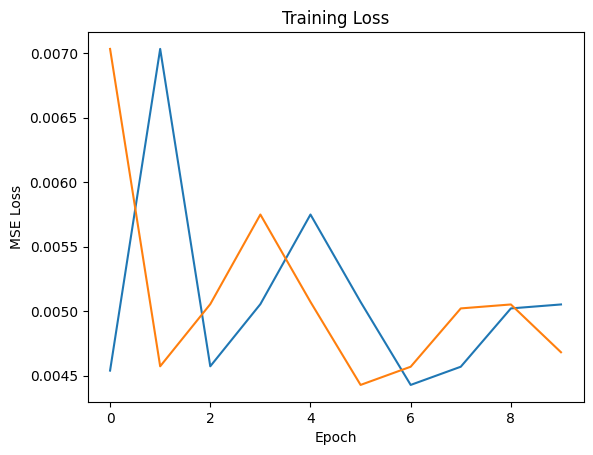

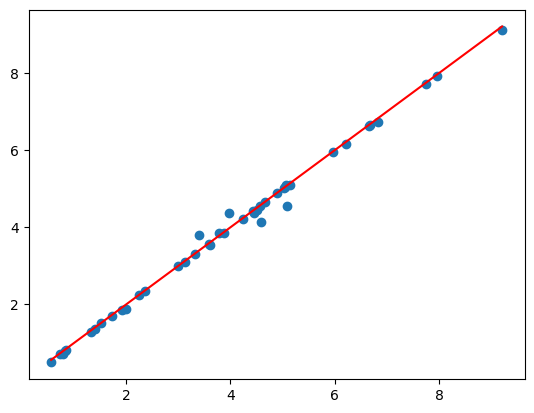

R² value: 0.9953


In [148]:
# Overfitting
best_model_state = None
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
losses = []
val_losses = []
best_loss = float('inf')
patience = 4
trigger_times = 0
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    
    val_loss = criterion(model(X_tensor), y_tensor).item()
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model)
            break

plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.show()

model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_true = y_scaler.inverse_transform(y_tensor.numpy())

# Plot predictions vs actual
plt.scatter(y_true, predictions)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.show()

r2 = r2_score(y_true, predictions)
print(f"R² value: {r2:.4f}")
torch.save(best_model_state, 'model.pth')

In [149]:
torch.save(model.state_dict(), 'IR_MLP.pth')

In [150]:
import pickle
with open('x_scaler.pkl', 'wb') as f:
    pickle.dump(x_scaler, f)
with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)
